In [1]:
# Imports et paths globaux
import rasterio
import numpy as np
import glob
import plotly.express as px
import plotly.graph_objs as go
import cv2
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shapely as sh
sns.set()

HOME = '/Users/u600141/OneDrive - La Francaise des Jeux/Data/constructions/'
PATHS_BDORTHO = HOME + 'images/BDORTHO_RGB/source/1_DONNEES_LIVRAISON_2022-06-00141/OHR_RVB_0M20_JP2-E080_LAMB93_D92-2021/*.jp2'
PATHS_BDTOPO = HOME + 'images/BDTOPO/source/1_DONNEES_LIVRAISON_2023-06-00117/BDT_3-3_SHP_LAMB93_D092-ED2023-06-15/*/*.shp'


In [3]:
# Chargement base BDTOPO : Fichiers .shp, avec un répertoire par thème (administratif, bâti, etc.)

# Lecture d'un fichier .shp
def load_shp(path):
    # Load data
    bdtopo = gpd.read_file(path)
    # Add Category and Type
    bdtopo.insert(0, 'Category', path.split('/')[-2])
    bdtopo.insert(1, 'Type', path.split('/')[-1][:-4])
    return bdtopo

# Lecture d'un fichier 
paths_shp = glob.glob(PATHS_BDTOPO)
bdtopo = load_shp(paths_shp[0])
for path in paths_shp[1:]:
    bdtopo = pd.concat([bdtopo, load_shp(path)])
bdtopo.reset_index(drop=True, inplace=True)

print (f'bdtopo chargé, taille {len(bdtopo)}')
bdtopo

bdtopo chargé, taille 996522


,Category,Type,ID,NATURE,NAT_DETAIL,TOPONYME,STATUT_TOP,IMPORTANCE,ETAT,DATE_CREAT,...,ADR_NUMERO,ADR_REP,ADR_COMPL,ADR_NOM_1,ADR_NOM_2,ID_BATI,ID_ENCEINT,NOMCOMMERC,SOURCES,ID_SOURCES
0,BATI,CONSTRUCTION_SURFACIQUE,CONSSURF0000002001889463,Dalle,Dalle urbaine,NaN,NaN,5,En service,2017-02-03 16:26:16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BATI,CONSTRUCTION_SURFACIQUE,CONSSURF0000000000419334,Dalle,Dalle urbaine,NaN,NaN,5,En service,2006-05-22 13:39:36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BATI,CONSTRUCTION_SURFACIQUE,CONSSURF0000000000419345,Dalle,Dalle de protection,NaN,NaN,5,En service,2006-05-22 13:39:36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BATI,CONSTRUCTION_SURFACIQUE,CONSSURF0000000000419330,Dalle,Dalle de protection,NaN,NaN,5,En service,2006-05-22 13:39:36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BATI,CONSTRUCTION_SURFACIQUE,CONSSURF0000000000419302,Pont,NaN,NaN,NaN,5,En service,2006-05-22 13:39:36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996517,OCCUPATION_DU_SOL,ZONE_DE_VEGETATION,ZONEVEGE0000002201437019,Haie,NaN,NaN,NaN,NaN,NaN,2019-02-08 09:45:11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996518,OCCUPATION_DU_SOL,ZONE_DE_VEGETATION,ZONEVEGE0000002201437018,Forêt fermée de feuillus,NaN,NaN,NaN,NaN,NaN,2019-02-08 09:45:11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996519,OCCUPATION_DU_SOL,ZONE_DE_VEGETATION,ZONEVEGE0000002201437017,Haie,NaN,NaN,NaN,NaN,NaN,2019-02-08 09:45:11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996520,OCCUPATION_DU_SOL,ZONE_DE_VEGETATION,ZONEVEGE0000000357962442,Vigne,NaN,NaN,NaN,NaN,NaN,2016-07-07 13:51:09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Ajout d'un champ GeoType indiquant le type d'objet géométrique
bdtopo['GeoType'] = bdtopo['geometry'].geom_type
print (bdtopo['GeoType'].value_counts(normalize=True))

GeoType
Polygon            0.745143
LineString         0.202817
Point              0.032434
MultiLineString    0.018965
MultiPolygon       0.000641
Name: proportion, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/geopandas/geodataframe.py:1538: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


In [5]:
# Ajout de l'aire

bdtopo['Area'] = bdtopo['geometry'].area


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/geopandas/geodataframe.py:1538: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


In [6]:
# Faut-il conserver les MultiPolygon ?

multipolygons_nb = bdtopo[bdtopo['GeoType'] == 'MultiPolygon'].count()
polygons_nb = bdtopo[bdtopo['GeoType'] == 'Polygon'].count()
print (f'Nb. multi-polygones / Nb. total (en %) : {100 * multipolygons_nb / (multipolygons_nb + polygons_nb)}')

multipolygons_area = bdtopo.loc[bdtopo['GeoType']=='MultiPolygon', 'Area'].sum()
polygons_area = bdtopo.loc[bdtopo['GeoType']=='Polygon', 'Area'].sum()
print (f'Surf. multi-polygones / Surf. totale (en %) : {100 * multipolygons_area / (multipolygons_area + polygons_area)}')


Nb. multi-polygones / Nb. total (en %) : Category      0.085981
Type          0.085981
ID            0.085981
NATURE        0.085874
NAT_DETAIL    0.434278
                ...   
NOMCOMMERC    0.000000
SOURCES            NaN
ID_SOURCES         NaN
GeoType       0.085981
Area          0.085981
Length: 217, dtype: float64
Surf. multi-polygones / Surf. totale (en %) : 1.28726281037583


In [8]:
# Nettoyage pour ne conserver que les Polygon et MultiPolygon

bdtopo = bdtopo[bdtopo['GeoType'].isin(['Polygon', 'MultiPolygon'])]
print (f'Nombre de polygones et multi-polygones : {len(bdtopo)} \n')
print (bdtopo.loc[bdtopo['Category']=='BATI', 'Type'].value_counts())

Nombre de polygones et multi-polygones : 743190 

Type
BATIMENT                   693693
TERRAIN_DE_SPORT             2895
CONSTRUCTION_SURFACIQUE       868
RESERVOIR                     609
CIMETIERE                     212
Name: count, dtype: int64


In [9]:
# Conservation des types à étudier uniquement

df = bdtopo[bdtopo['Type'].isin(['BATIMENT', 'RESERVOIR'])].reset_index()
print (f'Nombre de polygones et multi-polygones de type BATIMENT ou RESERVOIR : {len(df)} \n')
print (df['Type'].value_counts())


Nombre de polygones et multi-polygones de type BATIMENT ou RESERVOIR : 694302 

Type
BATIMENT     693693
RESERVOIR       609
Name: count, dtype: int64


In [10]:
# À quels types se rapportent les multi-polygones ?

gb = df.groupby(['GeoType', 'Type']).agg({'ID' : 'count', 'Area' : ['mean', 'max', 'sum']}).reset_index()
print (gb)

gb = df.groupby(['GeoType', 'Type', 'NATURE']).agg({'ID' : 'count', 'Area' : ['mean', 'max', 'sum']}).reset_index()
print (gb.head(30))

        GeoType       Type      ID          Area                         
                             count          mean        max           sum
0  MultiPolygon   BATIMENT     450   5357.954433  77125.070  2.411079e+06
1  MultiPolygon  RESERVOIR       1  81926.910000  81926.910  8.192691e+04
2       Polygon   BATIMENT  693243    161.172621  58171.615  1.117318e+08
3       Polygon  RESERVOIR     608    350.621579  33542.820  2.131779e+05
         GeoType       Type                                   NATURE      ID  \
                                                                       count   
0   MultiPolygon   BATIMENT                                   Eglise       3   
1   MultiPolygon   BATIMENT                           Indifférenciée     401   
2   MultiPolygon   BATIMENT       Industriel, agricole ou commercial      41   
3   MultiPolygon   BATIMENT                                     Silo       1   
4   MultiPolygon   BATIMENT                             Tour, donjon       2

Tous types de figures
------------------------------------

count    694302.000000
mean        164.824494
std         600.371746
min           0.205000
25%          22.440000
50%          70.215000
75%         131.080000
max       81926.910000
Name: Area, dtype: float64
            Type          NATURE   Area
537682  BATIMENT  Indifférenciée  0.205
             Type                                   NATURE      Area
694244  RESERVOIR  Réservoir d'eau ou château d'eau au sol  81926.91
Outliers - Nombre : 76377
Outliers - % nombre : 0.11000544431673825
Outliers - Aire : 69449914.06499714
Outliers - % aire : 0.6068782106426492


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: Futur

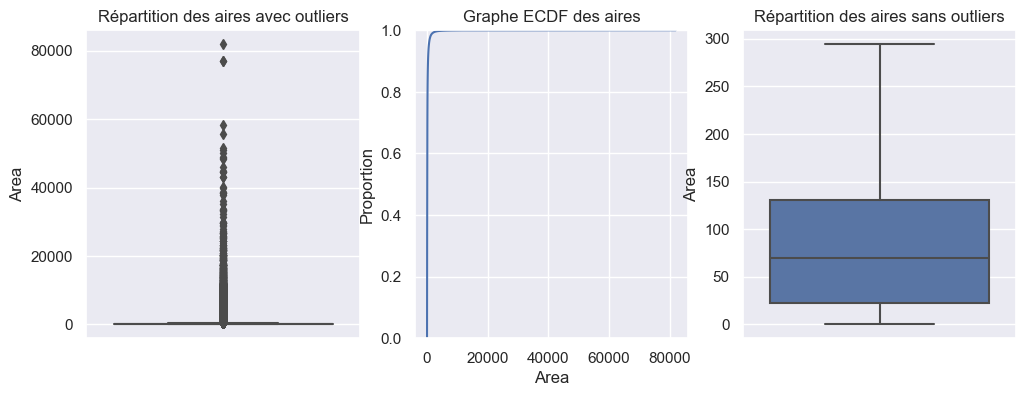

Polygones uniquement
------------------------------------

count    693851.000000
mean        161.338630
std         534.377742
min           0.205000
25%          22.415000
50%          70.160000
75%         130.875000
max       58171.615000
Name: Area, dtype: float64
            Type          NATURE   Area
537682  BATIMENT  Indifférenciée  0.205
            Type                              NATURE       Area
589053  BATIMENT  Industriel, agricole ou commercial  58171.615
Outliers - Nombre : 76062
Outliers - % nombre : 0.10962295939618161
Outliers - Aire : 66995617.36499697
Outliers - % aire : 0.5984692089897364


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: Futur

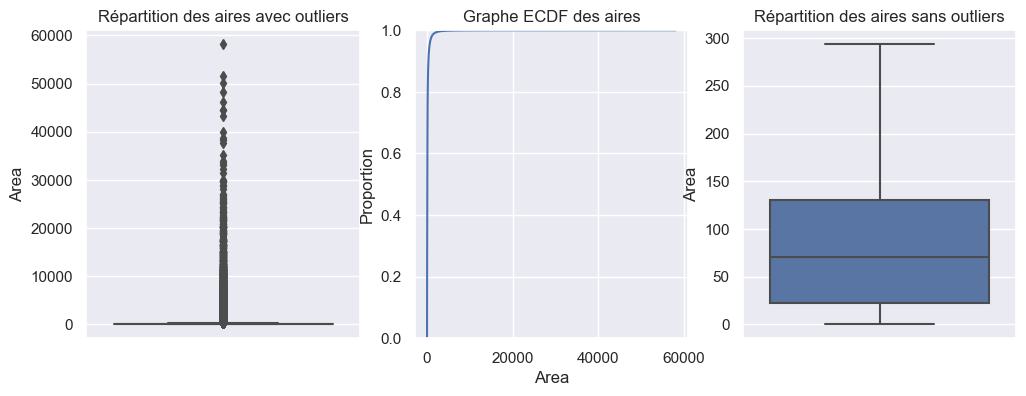

Mult-polygones uniquement
------------------------------------

count      451.000000
mean      5527.730388
std       9326.561596
min         96.215000
25%       1504.975000
50%       3213.120000
75%       5600.055000
max      81926.910000
Name: Area, dtype: float64
            Type          NATURE    Area
664375  BATIMENT  Indifférenciée  96.215
             Type                                   NATURE      Area
694244  RESERVOIR  Réservoir d'eau ou château d'eau au sol  81926.91
Outliers - Nombre : 38
Outliers - % nombre : 0.08425720620842572
Outliers - Aire : 1083779.725000047
Outliers - % aire : 0.43472801466789696


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: Futur

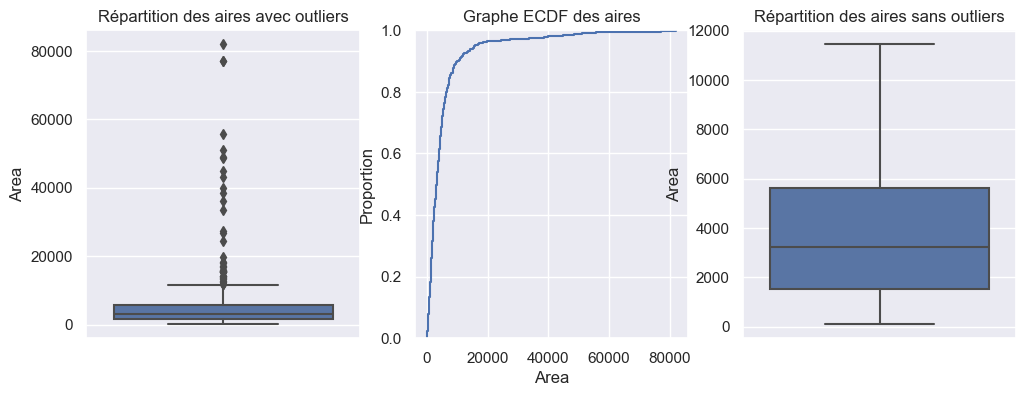

In [11]:
# Description de Area
def printOutliersProfile(data):
    q1, q3 = data.quantile(0.25), data.quantile(0.75)
    max_outliers_limit = q3 + 1.5 * (q3 - q1)
    outliers_nb = len(data.loc[data > max_outliers_limit])
    outliers_area = data.loc[data > max_outliers_limit].sum()
    print (f'Outliers - Nombre : {outliers_nb}')
    print (f'Outliers - % nombre : {outliers_nb / len(data)}')
    print (f'Outliers - Aire : {outliers_area}')
    print (f'Outliers - % aire : {outliers_area / data.sum()}')

def makeAreaDescription(df):
    print (df['Area'].describe())
    print (df.loc[df['Area']==df['Area'].min(), ['Type', 'NATURE', 'Area']])
    print (df.loc[df['Area']==df['Area'].max(), ['Type', 'NATURE', 'Area']])
    printOutliersProfile(df['Area'])

def makeAreaPlots(df):
    fig = plt.figure(figsize=(12, 4))
    fig.add_subplot(131)
    sns.boxplot(data=df, y='Area')
    plt.title('Répartition des aires avec outliers')
    fig.add_subplot(132)
    sns.ecdfplot(data=df, x='Area')
    plt.title('Graphe ECDF des aires')
    fig.add_subplot(133)
    sns.boxplot(data=df, y='Area', showfliers=False)
    plt.title('Répartition des aires sans outliers')
    plt.show();

print ('Tous types de figures')
print ('------------------------------------\n')
makeAreaDescription(df)
makeAreaPlots(df)

print ('Polygones uniquement')
print ('------------------------------------\n')
makeAreaDescription(df[df['GeoType']=='Polygon'])
makeAreaPlots(df[df['GeoType']=='Polygon'])

print ('Mult-polygones uniquement')
print ('------------------------------------\n')
makeAreaDescription(df[df['GeoType']=='MultiPolygon'])
makeAreaPlots(df[df['GeoType']=='MultiPolygon'])


         index Category      Type                        ID          NATURE  \
537682  553200     BATI  BATIMENT  BATIMENT0000000240636417  Indifférenciée   

       NAT_DETAIL TOPONYME STATUT_TOP IMPORTANCE        ETAT  ... ADR_COMPL  \
537682        NaN      NaN        NaN        NaN  En service  ...       NaN   

       ADR_NOM_1 ADR_NOM_2 ID_BATI ID_ENCEINT NOMCOMMERC SOURCES  ID_SOURCES  \
537682       NaN       NaN     NaN        NaN        NaN     NaN         NaN   

        GeoType   Area  
537682  Polygon  0.205  

[1 rows x 218 columns]
               x          y
537682  648417.9  6870329.0
537682  648417.0  6870328.8
537682  648417.2  6870329.3
537682  648417.9  6870329.0


<Axes: >

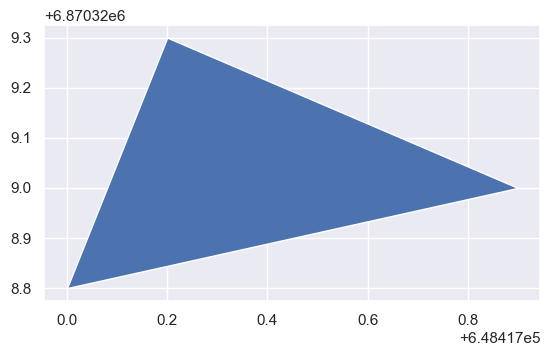

In [12]:
# Dessin du plus petit polygone de la base

f = df.loc[df['Area']==df['Area'].min()]
print (f)
print (f.get_coordinates())
f.plot()

         index Category       Type                        ID  \
694244  710466     BATI  RESERVOIR  RESERVOI0000000245022583   

                                         NATURE NAT_DETAIL TOPONYME  \
694244  Réservoir d'eau ou château d'eau au sol        NaN      NaN   

       STATUT_TOP IMPORTANCE        ETAT  ... ADR_COMPL ADR_NOM_1 ADR_NOM_2  \
694244        NaN        NaN  En service  ...       NaN       NaN       NaN   

       ID_BATI ID_ENCEINT NOMCOMMERC SOURCES  ID_SOURCES       GeoType  \
694244     NaN        NaN        NaN     NaN         NaN  MultiPolygon   

            Area  
694244  81926.91  

[1 rows x 218 columns]
               x          y
694244  642156.5  6861842.6
694244  642161.9  6861667.8
694244  642098.6  6861677.1
694244  642029.4  6861686.5
694244  641944.9  6861698.4
694244  641880.5  6861707.8
694244  641875.2  6861708.3
694244  641811.5  6861717.4
694244  641773.0  6861722.9
694244  641755.2  6861725.7
694244  641778.5  6861795.1
694244  641812.0  6861

<Axes: >

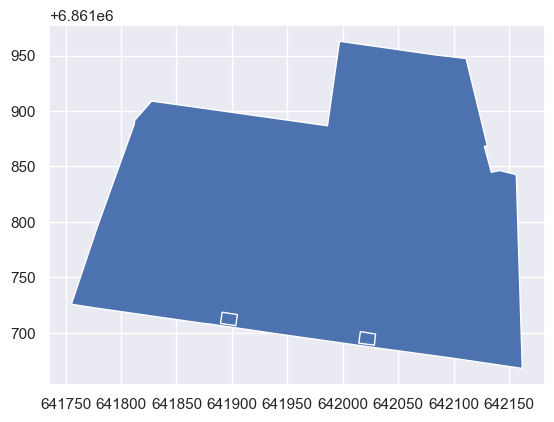

In [13]:
# Dessin du plus gros multi-polygone de la base

f = df.loc[df['Area']==df['Area'].max()]
print (f)
print (f.get_coordinates())
f.plot()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


count    694302.000000
mean          9.850909
std          10.782656
min           4.000000
25%           5.000000
50%           7.000000
75%          11.000000
max         875.000000
Name: NbPoints, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: Futur

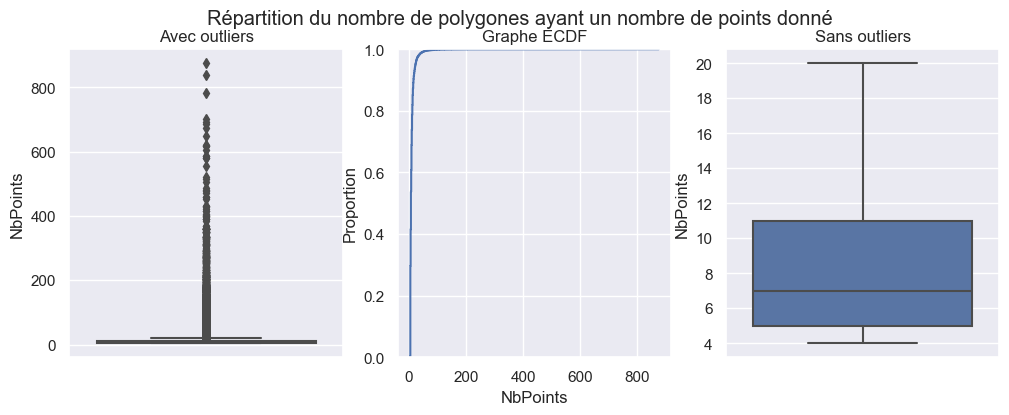

In [15]:
# Répartition du nombre de points par polygone

# Calcul et ajout d'une colonne 'NbPoints" au dataframe
def getVerticesCount(polygon):
    n = 0
    if polygon.geom_type.startswith("Multi"):
        n=0
        for part in polygon.geoms:
            n += len(part.exterior.coords)
    else:
        n += len(polygon.exterior.coords)
    return n
df.loc[:, 'NbPoints'] = df['geometry'].apply(getVerticesCount)

# Statistiques
print (df['NbPoints'].describe())

# Représentation graphique
fig = plt.figure(figsize=(12, 4))
fig.suptitle('Répartition du nombre de polygones ayant un nombre de points donné')
fig.add_subplot(131)
sns.boxplot(data=df, y='NbPoints')
plt.title('Avec outliers')
fig.add_subplot(132)
sns.ecdfplot(data=df, x='NbPoints')
plt.title('Graphe ECDF')
fig.add_subplot(133)
sns.boxplot(data=df, y='NbPoints', showfliers=False)
plt.title('Sans outliers')
plt.show();


5549    POLYGON Z ((644223.800 6853520.600 174.100, 64...
Name: geometry, dtype: geometry
             x          y
5549  644223.8  6853520.6
5549  644225.7  6853520.9
5549  644225.6  6853520.6
5549  644225.6  6853520.3
5549  644225.5  6853520.0
...        ...        ...
5549  644223.6  6853520.0
5549  644223.7  6853520.1
5549  644223.7  6853520.3
5549  644223.7  6853520.4
5549  644223.8  6853520.6

[875 rows x 2 columns]


<Axes: >

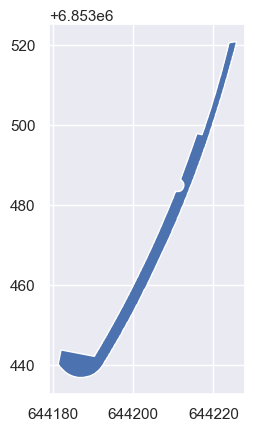

In [16]:
# Dessin du polygone le plus complexe de la base
f = df.loc[df['NbPoints']==df['NbPoints'].max(), 'geometry']
print (f)
print (f.get_coordinates())
f.plot()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

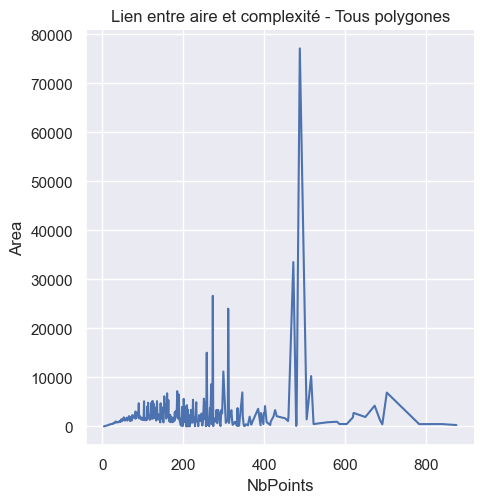

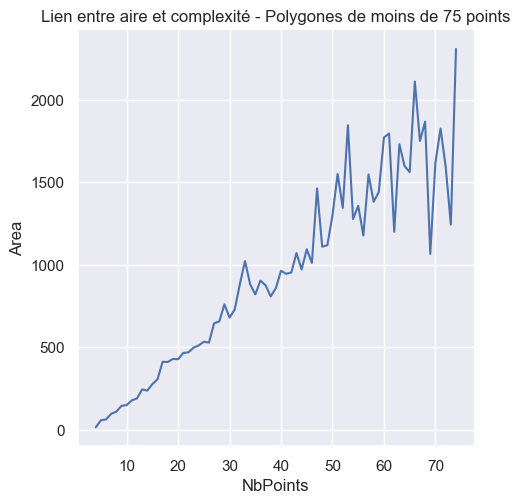

In [18]:
# Aire moyenne par complexité

gb = df.groupby('NbPoints').agg({'Area' : 'mean'}).reset_index()

sns.relplot(data=gb, x='NbPoints', y='Area', kind='line')
plt.title('Lien entre aire et complexité - Tous polygones')

sns.relplot( data=gb[gb['NbPoints']<75], x='NbPoints', y='Area', kind='line')
plt.title('Lien entre aire et complexité - Polygones de moins de 75 points')

plt.show();

In [20]:
# Test statistique  entre Area et NbPoints (Person)
# H0 : pas de corrélation entre les 2 variables
# H1 : variables corrélées

from scipy.stats import pearsonr

(coef, p_value) = pearsonr(gb['NbPoints'], gb['Area'])
print (f'Tous polygones : coef = {coef}, p-value  = {p_value}')

(coef, p_value) = pearsonr(gb.loc[gb['NbPoints']<75, 'NbPoints'], gb.loc[gb['NbPoints']<75, 'Area'])
print (f'Polygones de moins de 75 points : coef = {coef}, p-value  = {p_value}')
print ('Dans les 2 cas, la p-value est inférieure à 5% : on rejette H0. Les variables sont corrélées.')


Tous polygones : coef = 0.14782617611797447, p-value  = 0.006475923729418664
Polygones de moins de 75 points : coef = 0.948553446411231, p-value  = 3.467913900774076e-36
Dans les 2 cas, la p-value est inférieure à 5% : on rejette H0. Les variables sont corrélées.


In [28]:
# Préparation des rectangles correspondant aux images de la base BDORTHO
# La variable rectangles contient tous ces rectangles

# Lecture d'un fichier .tab (sans transformation, contrairement au starter-kit)
# On cherche les lignes de type : (640000.00,6860000.00) (0,0) Label "Pt 1",
def load_tabfile_no_transform(path):
    with open(path, 'r') as f:
        lines = f.readlines()
    coords = []
    for line in lines:
        if '(' in line and ')' in line:
            # récupère le premier tuple, eg. (640000.00,6860000.00)
            coord_str = line.split('(')[1].split(')')[0]
            coords.append(tuple(map(float, coord_str.split(','))))
    # coords contient les 4 tuples du fichier, eg. [(635000.0, 6860000.0), (640000.0, 6860000.0), (640000.0, 6855000.0), (635000.0, 6855000.0)]
    return coords

# Chargement de tous les fichies .tab et transformation en rectangles
paths_bdortho_tab = PATHS_BDORTHO.split('.')[:-1][0] + '.tab'
paths = glob.glob(paths_bdortho_tab)
rectangles = []
for f in paths:
    coords = load_tabfile_no_transform(f)
    xlist, ylist = [c[0] for c in coords], [c[1] for c in coords]
    x, y = min(xlist), min(ylist)
    width, height = max(xlist) - x, max(ylist) - y
    rectangles.append({'x' : x, 'y' : y,
                       'x1' : max(xlist), 'y1' : max(ylist),
                       'width' : width, 'height' : height,})
    

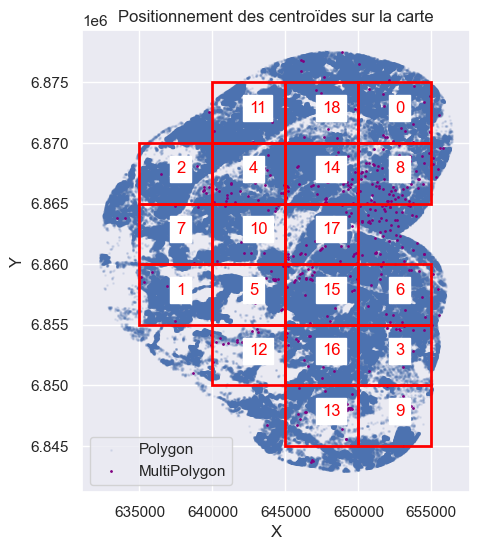

In [55]:
# Fonction de dessin des rectangles correspondant aux cartes BDORTHO
from matplotlib.patches import Rectangle

# Scatter de tous les centroïdes avec rectangles correspondant aux images
#    indices indique s'il faut afficher les numéros des rectangles
#    opacities est une liste avec le degré de noircissement de chaque rectangle
def drawRectangles(ax, rectangles, indices=True, opacities=None):
    edge_color_opacity = 1.0
    if (opacities==None):
        opacities = [0.0] * len(rectangles)
    for i, r in enumerate(rectangles):
        ax.add_patch(Rectangle((r['x'], r['y']), r['width'], r['height'],
                    edgecolor=(1, 0, 0, edge_color_opacity),
                    facecolor=(0, 0, 0, opacities[i]),
                    linewidth=2.0))
        if (indices==True):
            ax.text(r['x'] + r['width'] / 2,
                    r['y'] + r['height'] / 2,
                    str(i),
                    color='red', backgroundcolor='white')

# Scatters
fig = plt.figure(figsize=(5, 6))
ax = fig.add_subplot(111)
ax.scatter(x=df.loc[df['GeoType']=='Polygon','geometry'].centroid.x,
           y=df.loc[df['GeoType']=='Polygon','geometry'].centroid.y,
           c='b', alpha=0.1, s=1, edgecolor=None, label= 'Polygon')
ax.scatter(x=df.loc[df['GeoType']=='MultiPolygon','geometry'].centroid.x,
           y=df.loc[df['GeoType']=='MultiPolygon','geometry'].centroid.y,
           c='purple', alpha=1, s=1, edgecolor=None, label='MultiPolygon')
drawRectangles(ax, rectangles)
plt.title('Positionnement des centroïdes sur la carte')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show();

In [48]:
# Aire par carte BDORTHO : constitution de df_area (intersection de chaque ligne de df avec les rectangles)
# (multi-polygones exclus)

df_area = gpd.GeoDataFrame({'geometry' : df.loc[df['GeoType']=='Polygon', 'geometry']})
for r in rectangles:
    colname = '(' + str(int(r['x'])) + ',' + str(int(r['y'])) + ')'
    rect_poly = sh.Polygon([(r['x'], r['y']),
                            (r['x'] + r['width'], r['y']),
                            (r['x'] + r['width'], r['y'] + r['height']),
                            (r['x'], r['y'] + r['height'])])
    df_area[colname] = df_area['geometry'].intersection(rect_poly)
df_area = df_area.drop(columns=['geometry'])
df_area.head()


,"(650000,6870000)","(635000,6855000)","(635000,6865000)","(650000,6850000)","(640000,6865000)","(640000,6855000)","(650000,6855000)","(635000,6860000)","(650000,6865000)","(650000,6845000)","(640000,6860000)","(640000,6870000)","(640000,6850000)","(645000,6845000)","(645000,6865000)","(645000,6855000)","(645000,6850000)","(645000,6860000)","(645000,6870000)"
0,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,"POLYGON Z ((650888.400 6855897.400 61.400, 650...",POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY
1,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,"POLYGON Z ((650580.400 6856482.100 93.000, 650...",POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY
2,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,"POLYGON Z ((650599.600 6856523.800 91.000, 650...",POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY
3,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,"POLYGON Z ((650615.500 6856558.500 90.300, 650...",POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY
4,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,"POLYGON Z ((650569.500 6856519.400 90.800, 650...",POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY,POLYGON Z EMPTY


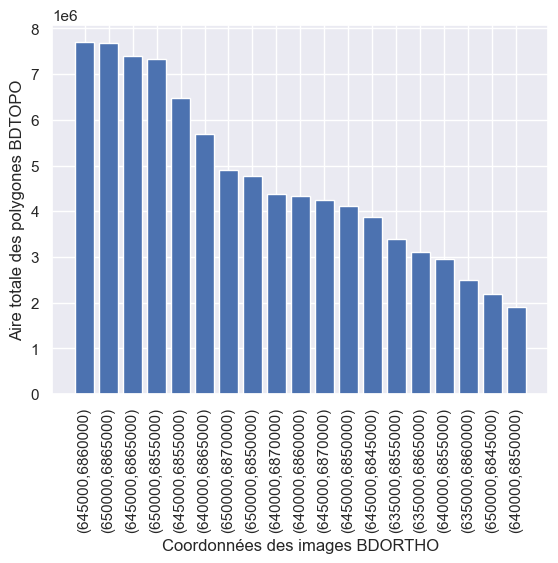

In [49]:
# Calcul et représentation graphique de la surface de df_areas par rectangle 
areas = df_area.apply(lambda col : col.area, axis=0).sum()
areas = areas.sort_values(ascending=False)

plt.bar(areas.index, areas)
plt.xlabel('Coordonnées des images BDORTHO')
plt.ylabel('Aire totale des polygones BDTOPO')
plt.xticks(rotation=90)
plt.show();


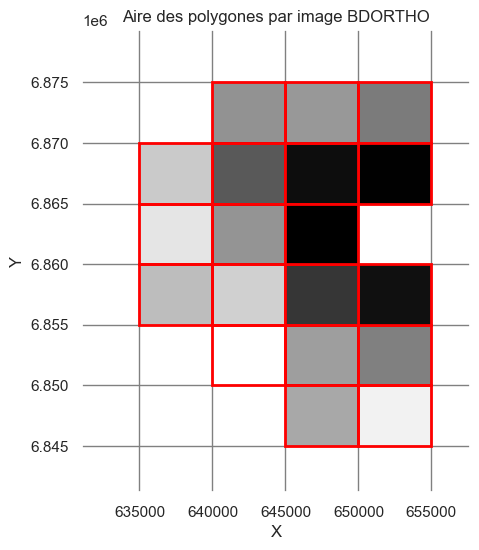

In [50]:
# On scale les areas pour utiliser ces valeurs comme transparence (couche alpha) du rectangle
df_areas_scaled = (areas - areas.min(axis=0)) / (areas.max(axis=0) - areas.min(axis=0))
df_areas_rect = pd.DataFrame({'Area' : areas, 'Scaled area' : df_areas_scaled}).reset_index()
df_areas_rect['x'] = df_areas_rect['index'].apply(lambda x : float(x.split(',')[0][1:]))
df_areas_rect['y'] = df_areas_rect['index'].apply(lambda x : float(x.split(',')[1][:-1]))

opacities = []
for i, r in enumerate(rectangles):
    opacity = df_areas_rect.loc[(df_areas_rect['x'] == r['x']) & (df_areas_rect['y'] == r['y']), 'Scaled area']
    opacities.append(list(opacity)[0])

fig = plt.figure(figsize=(5, 6))
ax = fig.add_subplot(111)
# le scatter plot est uniquement là pour mettre l'image à la bonne échelle
ax.scatter(x=df['geometry'].centroid.x, y=df['geometry'].centroid.y, c='b', alpha=0.0, s=1, edgecolor=None)
drawRectangles(ax, rectangles, indices=False, opacities=opacities)
plt.title('Aire des polygones par image BDORTHO')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(color='gray')
ax.set_facecolor('white')
plt.show();


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


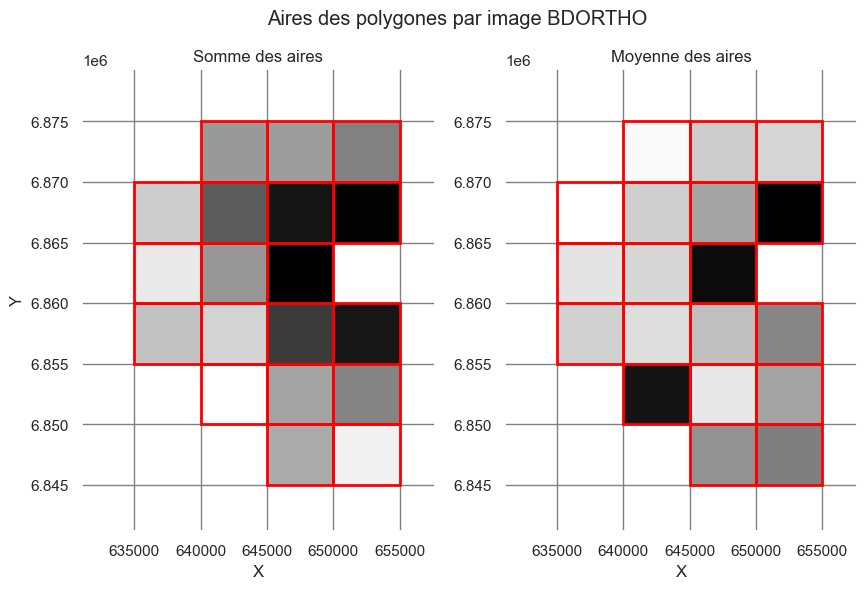

In [56]:
# Graphe des aires (totale et moyenne)

# Ajout de l'indice de rectangle à df
def getRectangle(x, y, rectangles):
    for i, r in enumerate(rectangles):
        if ((r['x']<x) and (x < r['x1']) and (r['y']<y) and (y<r['y1'])):
            return i
    return -1
df['Rectangle'] = df['geometry'].apply(lambda g : getRectangle(g.centroid.x, g.centroid.y, rectangles))

# Affichage de la carte des altitudes totales
# Calcul des altitudes totales par rectangle
gb = df[df['Area']>0].groupby(['Rectangle']).agg({'Area' : 'sum'}).reset_index()
gb = gb.set_index('Rectangle').drop(index=-1)
gb = (gb - gb.min()) / (gb.max() - gb.min())

fig = plt.figure(figsize=(10, 6))
plt.suptitle('Aires des polygones par image BDORTHO')

ax1 = fig.add_subplot(121)
# le scatter plot est uniquement là pour mettre l'image à la bonne échelle
ax1.scatter(x=df['geometry'].centroid.x, y=df['geometry'].centroid.y, c='b', alpha=0.0, s=1, edgecolor=None)
drawRectangles(ax1, rectangles, indices=False, opacities=list(gb['Area']))
plt.title('Somme des aires')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(color='gray')
ax1.set_facecolor('white')

# Affichage de la carte des altitudes moyennes
# Calcul des altitudes totales par rectangle
gb = df[df['Area']>0].groupby(['Rectangle']).agg({'Area' : 'mean'}).reset_index()
gb = gb.set_index('Rectangle').drop(index=-1)
gb = (gb - gb.min()) / (gb.max() - gb.min())

ax2 = fig.add_subplot(122)
# le scatter plot est uniquement là pour mettre l'image à la bonne échelle
ax2.scatter(x=df['geometry'].centroid.x, y=df['geometry'].centroid.y, c='b', alpha=0.0, s=1, edgecolor=None)
drawRectangles(ax2, rectangles, indices=False, opacities=list(gb['Area']))
plt.title('Moyenne des aires')
plt.xlabel('X')
plt.grid(color='gray')
ax2.set_facecolor('white')

plt.show();

In [58]:
# Calcul de l'altitude des polygones (point le plus haut par polygone)

df['Altitude max'] = df.loc[df['GeoType']=='Polygon', 'geometry'].apply(
    lambda g : np.array(g.exterior.coords)[:,2].max())



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Répartition des altitudes maximales dans la base
count    693851.000000
mean        -70.713737
std         367.699981
min       -1000.000000
25%          41.200000
50%          57.900000
75%          88.100000
max         320.400000
Name: Altitude max, dtype: float64

Répartition des altitudes maximales des polygones à altitude négative
count    93339.0
mean     -1000.0
std          0.0
min      -1000.0
25%      -1000.0
50%      -1000.0
75%      -1000.0
max      -1000.0
Name: Altitude max, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


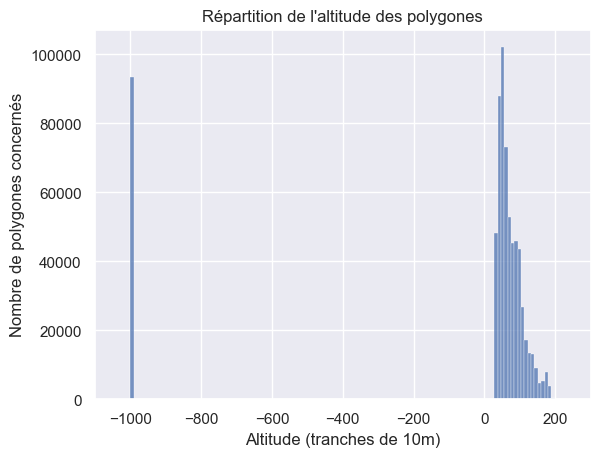

In [62]:
# Problème des altitudes négatives : régularisation

print ('Répartition des altitudes maximales dans la base')
print (df['Altitude max'].describe())

print ('\nRépartition des altitudes maximales des polygones à altitude négative')
print (df.loc[df['Altitude max']<0, 'Altitude max'].describe())

sns.histplot(data=df, x='Altitude max', bins=140)
plt.title('Répartition de l\'altitude des polygones' )
plt.xlim((-1100, 300))
plt.xlabel('Altitude (tranches de 10m)')
plt.ylabel('Nombre de polygones concernés')
plt.show();


count    600512.000000
mean         73.727424
std          33.579488
min          24.800000
25%          48.200000
50%          63.900000
75%          93.000000
max         320.400000
Name: Altitude max, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


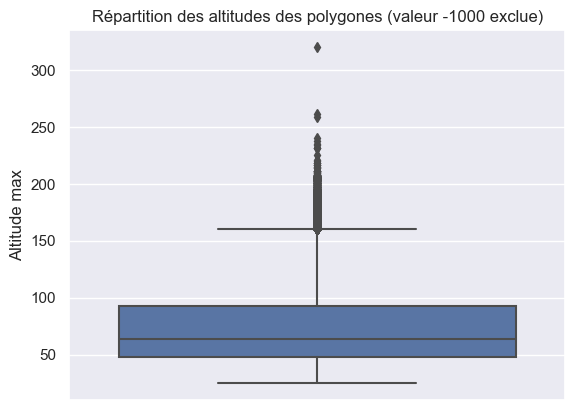

In [63]:
# Boxplot des altitudes positives

print (df.loc[df['Altitude max']>0, 'Altitude max'].describe())
sns.boxplot(data=df[df['Altitude max']>0], y='Altitude max')
plt.title('Répartition des altitudes des polygones (valeur -1000 exclue)')
plt.show();

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


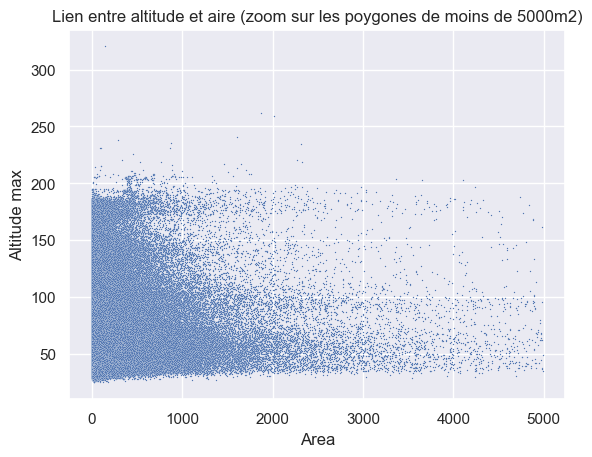

In [64]:
# Lien entre altitude maximale et surface

sns.scatterplot(data=df[(df['Area']<5000) & (df['Altitude max']>0)], x='Area', y='Altitude max', s=1)
plt.title ('Lien entre altitude et aire (zoom sur les poygones de moins de 5000m2)')
plt.show();

In [65]:
# isna(), has_z

print (df['geometry'].isna().sum())
print (df['geometry'].geometry.has_z.count())
print (len(df))

0
694302
694302


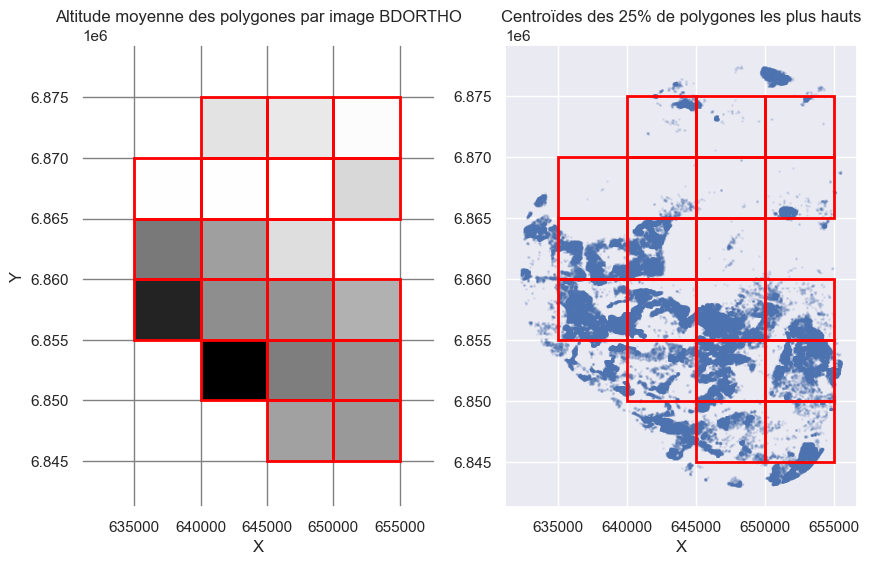

In [67]:
# Graphe des altitudes moyennes

# Moyenne des altitudes par rectangle
gb = df[df['Altitude max']>0].groupby(['Rectangle']).agg({'Altitude max' : 'mean'}).reset_index()

gb = gb.set_index('Rectangle').drop(index=-1)
gb = (gb - gb.min()) / (gb.max() - gb.min())

# Affichage de la carte des altitudes
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(121)
# scatter pour l'échelle uniquement
ax1.scatter(x=df['geometry'].centroid.x, y=df['geometry'].centroid.y, c='b', alpha=0.0, s=1, edgecolor=None)
drawRectangles(ax1, rectangles, indices=False, opacities=list(gb['Altitude max']))
plt.title('Altitude moyenne des polygones par image BDORTHO')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(color='gray')
ax1.set_facecolor('white')

# Scatter des 100 plus hauts polygones
dfmaxalti = df[df['Altitude max']>df['Altitude max'].quantile(0.75)]
ax2 = fig.add_subplot(122)
ax2.scatter(x=dfmaxalti['geometry'].centroid.x, y=dfmaxalti['geometry'].centroid.y, c='b', alpha=0.1, s=1, edgecolor=None)
plt.title('Centroïdes des 25% de polygones les plus hauts')
plt.xlabel('X')
plt.ylabel('')
drawRectangles(ax2, rectangles, indices=False)
plt.show();

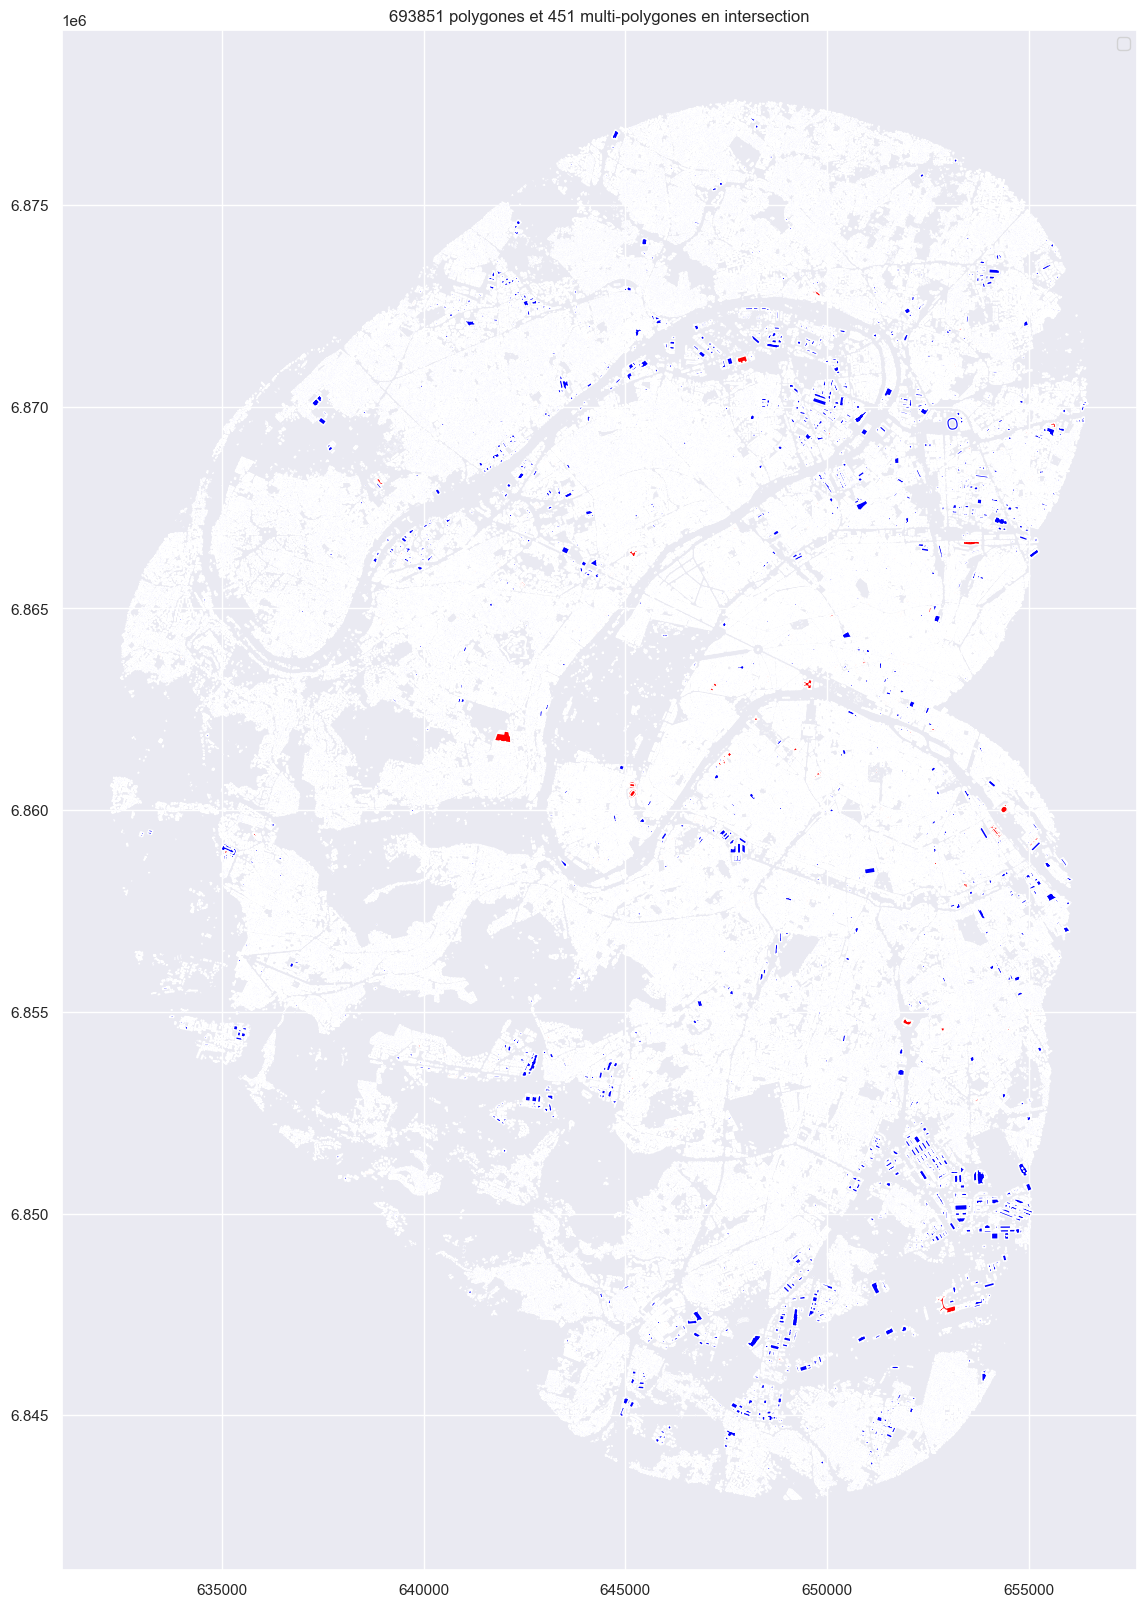

In [72]:
# Affichage de BDTOPO : Polygons et MultiPolygons
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
df.loc[df['GeoType']=='Polygon', 'geometry'].plot(ax=ax, color='blue')
df.loc[df['GeoType']=='MultiPolygon', 'geometry'].plot(ax=ax, color='red')
plt.title(str(len(df[df['GeoType']=='Polygon'])) + ' polygones et ' + str(len(df[df['GeoType']=='MultiPolygon'])) + ' multi-polygones en intersection')
plt.legend(['Polygon', 'MultiPolygon'])
plt.show();
